 # Getting started with granite-geospatial-uki-flood-detection

This notebook demonstrates how to use the granite-geospatial-uki-flood-detection model hosted on Hugging Face for the segmentation of flood events.

The granite-geospatial-uki-flood-detection model is a fine-tuned geospatial foundation model for detecting flood and surface water using multispectral and synthetic aperture radar (SAR) satellite imagery. The model predicts areas of water from Sentinel-2 and Sentinel-1 SAR imagery and was trained on flood events from the United Kingdom and Ireland, recorded by the [Copernicus Emergency Management service (CEMS)](https://emergency.copernicus.eu/).  Please see the [model card](../granite-geospatial-flood-detection-uki-model-card.md) for more details. The model was fine-tuned from the [granite-geospatial-uki model](../granite-geospatial-uki-model-card.md),
this model follows the same architecture as [Prithvi-EO](https://huggingface.co/collections/ibm-nasa-geospatial/prithvi-for-earth-observation-6740a7a81883466bf41d93d6) and has also been released.

Our experiments have shown that while granite-geospatial-uki-flood-detection works best in the UK and Ireland, the base model granite-geospatial-uki can also be successfully fine-tuned for flood detection in other locations. To learn more about fine tuning the base model to other locations, please see the [fine tuning notebook](../notebooks/2_fine_tuning.ipynb), which demonstrates fine tuning and inference for Spain.

This notebook demonstrates how to run inference using [**granite-geospatial-uki-flood-detection-v1**](../granite-geospatial-flood-detection-uki-model-card.md) (which was fine tuned on UK and Ireland data) and is split into two parts:

1. Inference: The [**granite-geospatial-uki-flood-detection-v1**](../granite-geospatial-flood-detection-uki-model-card.md) model is loaded and used to run inference on test data for flood events across UK and Ireland that were not seen in the training data.

2. Evaluation. We compare the model above against inference results trained using only Sentinel-2 and show the improvement in performance by incorporating Sentinel-1 data, in particular in the presence of clouds.

Please note:

This example uses the fine tuned model for UK and Ireland (granite-geospatial-uki-flood-detection-v1). To use the model fine-tuned for Spain instead please see [2_fine_tuning-tuning.ipynb](./2_fine_tuning.ipynb).



  ## Setting up your environment

  The granite-geospatial-uki-flood-detection model is trained using the [Terratorch](https://github.com/IBM/terratorch/) framework. Terratorch simplifies the integration of foundation model backbones into the TorchGeo framework and provides generic LightningDataModules that can be built at runtime. For more information on Terratorch, please refer to the instructions in the [Terratorch Quick Start Guide](https://github.com/IBM/terratorch/blob/main/docs/quick_start.md). To set up your environments for running this notebook on Google Colab, please see section 0.1. If you plan to run this notebook on a local machine please see section 0.2 instead for set-up instructions.

### 0.1 set-up for running on Google Colab
You may want to take this opportunity to double check you're using GPUs on Google Colab before proceeding any further. We have tested this notebook using T4 GPU on the free colab account. 

#### 0.1.1 check python version
It's recommended that you run this notebook using python 3.12. Let's check the python version by executing the cell below.

In [ ]:
!python --version

Python 3.12.11


#### 0.1.2 setting up your environment
To install the necessary packages, execute the cell below. This will take a few minutes. Once the installation process is done, a window will pop up to ask you to restart the session. This is normal and you should proceed to restart using the interface in the pop up window. Once the session has restarted, it's important that you ignore the cell below, and go straight to section 0.0.3.

In [ ]:
import sys

# if running on colab
if "google.colab" in sys.modules:
    # Clone the ibm-granite GitHub repo
    !git clone https://github.com/ibm-granite/geospatial.git
    # Install the package
    %pip install -e ./geospatial/uki-flooddetection[colab]   

#### 0.1.3 Set up working directory
This is the first thing you should run after restarting your Colab session.

In [ ]:
import sys

# Only run this cell if running on Colab.
if "google.colab" in sys.modules:
    # Change to the notebooks directory
    %cd geospatial/uki-flooddetection/notebooks
    %pwd

Now your environment is set up for Google Colab. Please proceed to section 0.3.

### 0.2 set-up for running on your local machine

Before running through this notebook it's best to create a virtual environment and install the necessary packages there before running this notebook. The instructions can be found in [README.md](../README.md).

  Once that's done, come back to this notebook and make sure it's using the newly made virtual environment.

  Please proceed to section 0.3.

### 0.3 importing packages and setting up paths

In [4]:
# imports
import os
import re
from collections import defaultdict
from pathlib import Path

import pandas as pd
from granite_geo_flood.utils.helper import (
    calc_metrics,
    compare_images_label_pred,
    download_data,
    gather_truth_and_pred,
)
from huggingface_hub import hf_hub_download

In [5]:
# some initial set-up
%matplotlib inline

project_root = Path("../")
hf_repo_name = "ibm-granite/granite-geospatial-uki-flooddetection"

Let's also set up something that is common across both models.

In [6]:
# indices of RGB bands, in order, in the input images of size (h x w x bands)
rgb_bands = [
    4,
    3,
    2,
]

# index of VV band, in the input images of size (h x w x bands)
vv_band = 0

 ## 1. Sentinel-2 and Sentinel-1 model (granite-geospatial-uki-flood-detection)

 This fine-tuned model used Sentinel-2 [Blue, Green , Red, Narrow NIR, SWIR 1, SWIR 2, cloud] and Sentinel-1 [VV, VH] bands, and used the granite-geospatial-uki pre-trained model.


### 1.1 Prepare data

 Let's gather and specify the relevant files for carrying out inference in a new folder.

In [ ]:
# download model config
config_name = "config.yaml"
config_folder = project_root / "configs"

config_file = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=config_name,
        local_dir=config_folder,
    )
)

# rename the config file so that it doesn't get overwritten if using both notebooks
config_file = config_file.replace(
    config_folder / "config_granite_geospatial_uki_flood_detection_v1.yaml"
)

In [ ]:
# download model checkpoint
checkpoint_name = "granite_geospatial_uki_flood_detection_v1.ckpt"
checkpoint_folder = project_root / "data" / "checkpoints"

inference_checkpoint = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=checkpoint_name,
        local_dir=checkpoint_folder,
    )
)

In [9]:
# specify where you want to save your inference results
model_name = "granite_geospatial_uki_flood_detection_v1"
inference_dir = project_root / "data" / "inference" / model_name

# specify where the test images are stored
data_path = project_root / "data" / "regions"
os.makedirs(data_path, exist_ok=True)
data_dir = data_path / "uki" / "holdout" / "images"

In [ ]:
# Download data and uncompress
save_file = (
    project_root / "data" / "granite-geospatial-uki-flooddetection-dataset-uki.tar.gz"
)
download_data("uki", save_file)
command = f'tar -xf "{str(save_file)}" --directory "{str(data_path)}"'
os.system(command)

  ### 1.2 Run Inference

Let's carry out inference on the test images. The test images are samples from the following flood events: 
- [EMSR407](https://emergency.copernicus.eu/mapping/list-of-components/EMSR407): North of England, November 2019 
- [EMSR429](https://emergency.copernicus.eu/mapping/list-of-components/EMSR429): Ireland, February 2020
- [EMSR698](https://rapidmapping.emergency.copernicus.eu/EMSR698/): Scotland, October 2023
 
Execute the cell below to print out a command. Check that all the paths look ok. If it looks good, execute the command in the next cell.

Please note: **Granite-geospatial-uki** is not a standard model in Terratorch. To load the model (or any custom backbone) we can put the model file in a folder called `custom_modules`. In this example the file is called `granite_geospatial_uki.py`. If you're planning to run this command outside of this notebook when applying to your own project, it's important to **make sure you're running terratorch from the directory where the `custom_modules` folder is located**.  



In [11]:
# run inference
command = f"terratorch predict -c ./{config_file} --ckpt_path ./{inference_checkpoint} --predict_output_dir ./{inference_dir} --data.init_args.predict_data_root ./{data_dir}"
print(command)

terratorch predict -c ./../configs/config_granite_geospatial_uki_flood_detection_v1.yaml --ckpt_path ./../data/checkpoints/granite_geospatial_uki_flood_detection_v1.ckpt --predict_output_dir ./../data/inference/granite_geospatial_uki_flood_detection_v1 --data.init_args.predict_data_root ./../data/regions/uki/holdout/images


In [ ]:
os.system(command)

In [13]:
# saving this to use in section 3
inf_dir_pretrain = inference_dir

 ## 2. Load pre-calculated inference from a Sentinel-2-only model

For comparison, we use a model which was fine-tuned from [Prithvi-100M](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M), which was pre-trained on Harmonised Landsat and Sentinel-2 data for the US and does not include SAR data. For your convenience, we have already run inference for this model. Let's gather and specify the relevant files.

In [14]:
inf_dir_HLS = project_root / "resources" / "s2_only_inference"

## 3. Model comparison

Let's have a look at some inference examples. Let's pick images which have a range of cloud conditions to get a feel for the full-spectrum of model performance. We load and plot the data below.

In [15]:
example_images = [
    "EMSR407_AOI_3_2019-11-14_tile_0_2",  # mostly cloud-free
    "EMSR698_AOI_36_2023-10-10_tile_4_1",  # half cloudy
    "EMSR429_AOI_55_2020-02-26_tile_0_2",  # very cloudy
]

In [16]:
# find the relevant data
label_dir = data_dir.parent / "labels"
truth_labels = sorted(list(label_dir.rglob("EMSR*test*label.tif")))
pred_labels_HLS = sorted(list(inf_dir_HLS.rglob("EMSR*test*image_pred.tif")))
pred_labels_granite = sorted(list(inf_dir_pretrain.rglob("EMSR*test*image_pred.tif")))
input_images = sorted(list(data_dir.rglob("EMSR*test*image.tif")))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004316546762589928..3.3553956834532372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0469583778014941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3255587949465502].


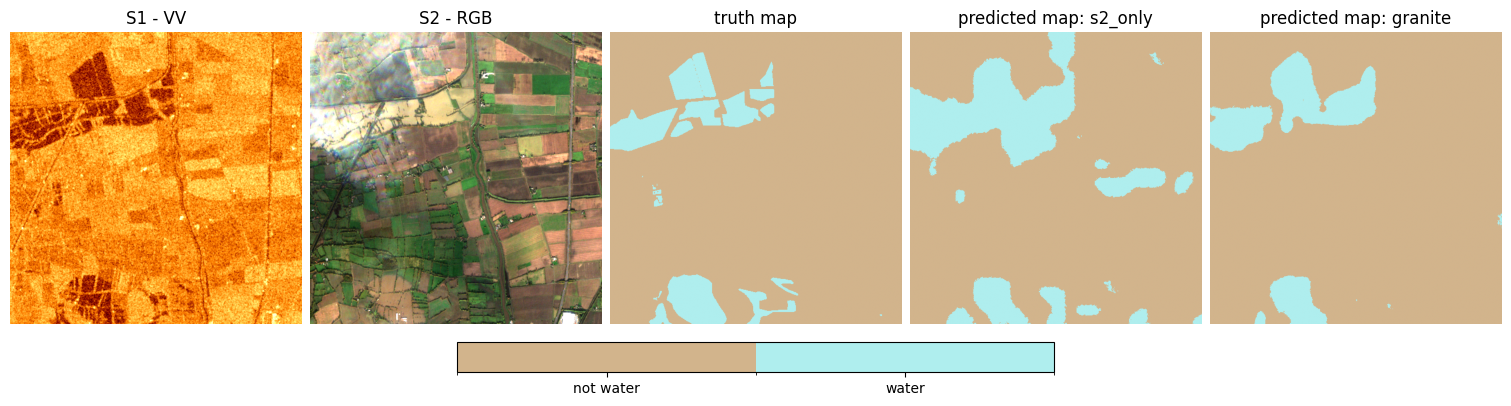

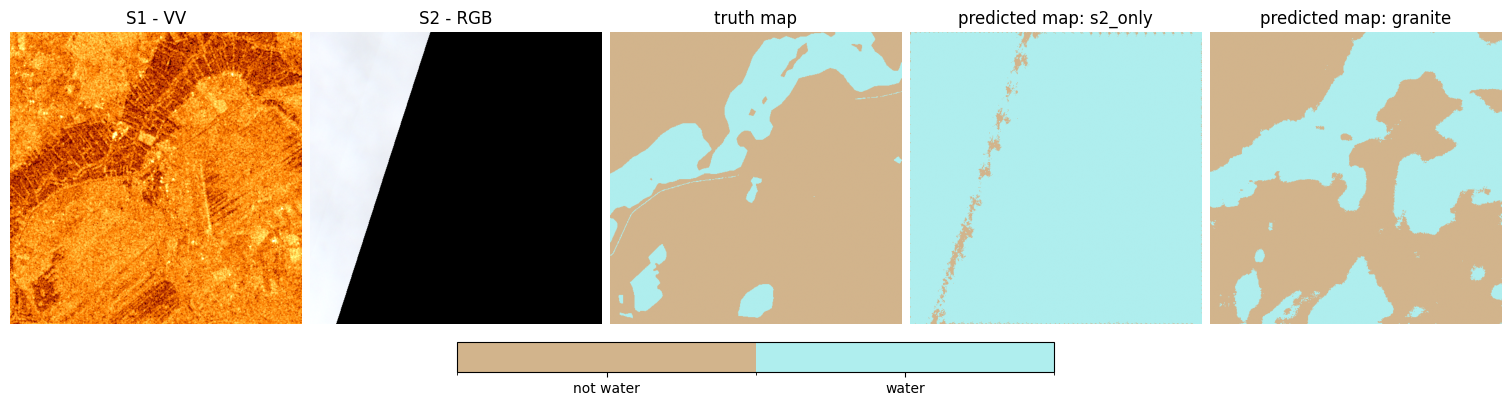

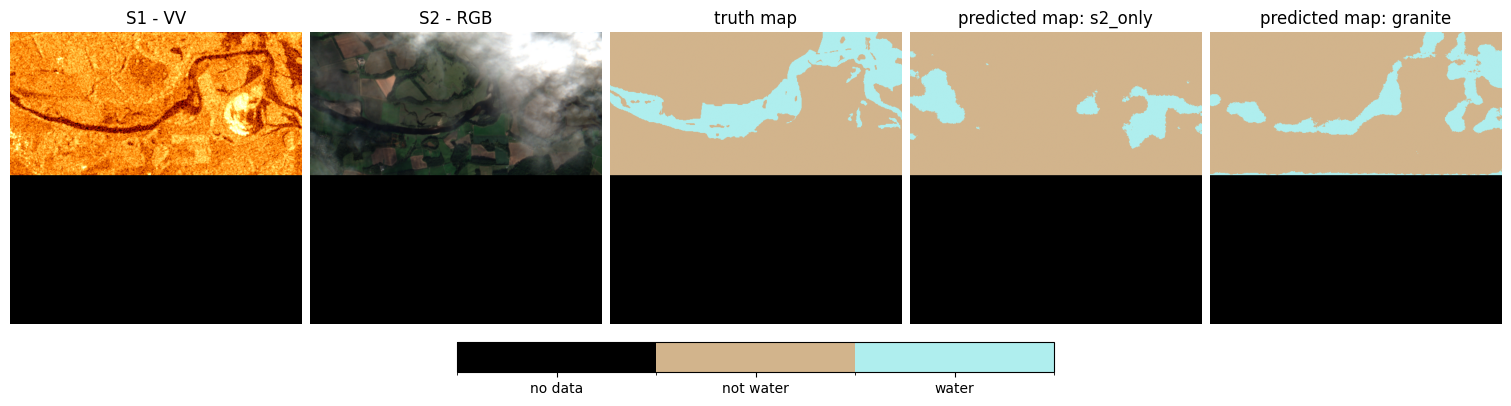

In [17]:
# defining where to save the data
save_dir = project_root / "plots" / "uki_model_comparison"

search_pattern = "(.*_\\d{4}-\\d{2}-\\d{2}_tile_\\d_\\d)"

os.makedirs(save_dir, exist_ok=True)
for plot_data in zip(input_images, truth_labels, pred_labels_HLS, pred_labels_granite):
    file_stem = re.findall(search_pattern, plot_data[0].stem)[0]
    if file_stem in example_images:
        compare_images_label_pred(
            plot_data[0],
            plot_data[1],
            plot_data[2],
            plot_data[3],
            "s2_only",
            "granite",
            vv_band,
            rgb_bands,
            save_dir,
        )

We see a few things here. 
1. Where pixels have both S1 and cloud-free S2 data available, the granite-geospatial-uki-flood-detection model has comparible performance to the S2-only model. (e.g. the top figure)
2. Where there's heavy cloud coverage, the granite-geospatial-uki-flood-detection model helps with flood segmentation performance, helped by the additional S1 bands. (e.g. under cloud-covered areas in the middle and lower figures).
3. Where there is S1 imagery available but no S2, there may be some model artefacts. Some possible reasons for this could be due to not having enough of this type of scenario in the training set, or it could also be because the missing value regions are being confused with water in the model. (e.g. the right half of the middle figure, where S2 data is missing).

To safeguard predictions we recommend to only run inference on images where S1 and S2 are available across the whole field of view. If you wish to use only S1 data, we advise to fine-tune the granite-geospatial-uki model using S1 only data. An example on how to fine-tune using our model can be found in the notebook [2_fine_tuning.ipynb](./2_fine_tuning.ipynb). This demonstrates the use of different model configurations (config_granite_geospatial_uki_flood_detection_v2.yaml) and weights (granite_geospatial_uki_flood_detection_v2.ckpt) when carrying out fine-tuning and inference for a different region.

We will now evaluate the model performance on the "good" images i.e. where flooding can be seen in all bands (5 images). We compare this to an evaluation using on all test images (9 images), which includes those with clouds.

In [18]:
good_images = [
    "EMSR407_AOI_3_2019-11-14_tile_0_2",
    "EMSR407_AOI_3_2019-11-14_tile_1_1",
    "EMSR429_AOI_5_2020-03-02_tile_2_1",
    "EMSR429_AOI_5_2020-03-02_tile_3_2",
    "EMSR429_AOI_61_2020-02-26_tile_2_3",
]

In [19]:
metric_dict = defaultdict(float)

# evaluating on all images for HLS model
pred_files, truth_files = gather_truth_and_pred(inf_dir_HLS, label_dir, "test")
metric_dict["S2 only model | all images (9 images)"] = calc_metrics(
    truth_files, pred_files
)

truth_files_good = [
    truth_file
    for truth_file in truth_files
    if truth_file.stem.split("_test")[0] in good_images
]
pred_files_good = [
    pred_file
    for pred_file in pred_files
    if pred_file.stem.split("_test")[0] in good_images
]
metric_dict["S2 only model | good images (5 images)"] = calc_metrics(
    truth_files_good, pred_files_good
)

# evaluating on all images for additional bands model
pred_files, truth_files = gather_truth_and_pred(inf_dir_pretrain, label_dir, "test")
metric_dict["granite-geospatial-uki-flood-detection-v1 | all images (9 images)"] = (
    calc_metrics(truth_files, pred_files)
)

truth_files_good = [
    truth_file
    for truth_file in truth_files
    if truth_file.stem.split("_test")[0] in good_images
]
pred_files_good = [
    pred_file
    for pred_file in pred_files
    if pred_file.stem.split("_test")[0] in good_images
]
metric_dict["granite-geospatial-uki-flood-detection-v1 | good images (5 images)"] = (
    calc_metrics(truth_files_good, pred_files_good)
)

In [20]:
# gathering metrics into a table
metrics = pd.DataFrame.from_dict(metric_dict, orient="index").reset_index()
metrics[["index", "eval_target"]] = metrics["index"].str.split("|", expand=True)
metrics.rename(columns={"index": "model"}, inplace=True)
metrics = metrics[["model", "eval_target", "mIoU", "F1"]]

display(metrics)

,model,eval_target,mIoU,F1
0,S2 only model,all images (9 images),0.571205,0.820831
1,S2 only model,good images (5 images),0.725809,0.925691
2,granite-geospatial-uki-flood-detection-v1,all images (9 images),0.789000,0.939081
3,granite-geospatial-uki-flood-detection-v1,good images (5 images),0.849667,0.968009


We see that both the Sentinel-2 only model and the granite-geospatial-uki-flood-detection model perform well when evaluating on the "good" images (i.e. mostly cloud-free / has good spatial coverage), see rows 1 and 3 above. Whereas when we compare all images, which includes more challenging images in the evaluation, the additional bands model granite-geospatial-uki-flood-detection helped increase the mIoU of this particular dataset by about 22 percentage points, which is an increase of approximately 38%. 


## Next steps
To learn how to fine tune the base granite-geospatial-uki model for flood detection in a different location, check out the [2_fine_tuning](./2_fine_tuning.ipynb)  notebook.